In [10]:
import sys

#if branch is stable, will install via pypi, else will install from source
branch = "stable"
IN_COLAB = "google.colab" in sys.modules

if IN_COLAB and branch == "stable":
    !pip install --quiet scvi-tools[tutorials]
elif IN_COLAB and branch != "stable":
    !pip install --quiet --upgrade jsonschema
    !pip install --quiet git+https://github.com/yoseflab/scvi-tools@$branch#egg=scvi-tools[tutorials]

     |████████████████████████████████| 204kB 27.5MB/s 
     |████████████████████████████████| 245kB 40.0MB/s 
     |████████████████████████████████| 215kB 38.2MB/s 
     |████████████████████████████████| 81kB 12.4MB/s 
     |████████████████████████████████| 819kB 53.3MB/s 
     |████████████████████████████████| 133kB 45.9MB/s 
     |████████████████████████████████| 634kB 55.7MB/s 
     |████████████████████████████████| 11.3MB 53.0MB/s 
     |████████████████████████████████| 3.2MB 33.8MB/s 
     |████████████████████████████████| 8.8MB 49.9MB/s 
     |████████████████████████████████| 51kB 8.3MB/s 
     |████████████████████████████████| 1.4MB 46.7MB/s 
     |████████████████████████████████| 51kB 8.2MB/s 
     |████████████████████████████████| 829kB 62.0MB/s 
     |████████████████████████████████| 645kB 50.0MB/s 
     |████████████████████████████████| 235kB 64.1MB/s 
     |████████████████████████████████| 122kB 53.9MB/s 
     |████████████████████████████████| 10.6MB 49.3M

In [11]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd

import scanpy as sc
import scvi

sc.set_figure_params(figsize=(4, 4))

/usr/local/lib/python3.7/dist-packages/numba/np/ufunc/parallel.py:363: NumbaWarning: The TBB threading layer requires TBB version 2019.5 or later i.e., TBB_INTERFACE_VERSION >= 11005. Found TBB_INTERFACE_VERSION = 9107. The TBB threading layer is disabled.
  warnings.warn(problem)


In [12]:
dataset1 = sc.read(
    "data/TM_droplet.h5ad",
    backup_url="https://s3.amazonaws.com/czbiohub-tabula-muris/TM_droplet_mat.h5ad",
)
dataset2 = sc.read(
    "data/TM_facs.h5ad",
    backup_url="https://s3.amazonaws.com/czbiohub-tabula-muris/TM_facs_mat.h5ad",
)
dataset1.obs = pd.read_csv(
    "https://github.com/czbiohub/tabula-muris-vignettes/raw/master/data/TM_droplet_metadata.csv"
)
dataset2.obs = pd.read_csv(
    "https://github.com/czbiohub/tabula-muris-vignettes/raw/master/data/TM_facs_metadata.csv",
)

  0%|          | 0.00/236M [00:00<?, ?B/s]

  0%|          | 0.00/465M [00:00<?, ?B/s]

/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:2718: DtypeWarning: Columns (4,9) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [13]:
# subset to labelled bone marrow cells because it's a reasonably sized dataset that'll allow us to validate our method's ability to transfer labels from one dataset to another
dataset1 = dataset1[
    (dataset1.obs.tissue == "Marrow") & (~dataset1.obs.cell_ontology_class.isna())
].copy()
dataset2 = dataset2[
    (dataset2.obs.tissue == "Marrow") & (~dataset2.obs.cell_ontology_class.isna())
].copy()

/usr/local/lib/python3.7/dist-packages/anndata/_core/anndata.py:120: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


In [14]:
dataset1.shape, dataset2.shape

((3652, 23433), (5037, 23433))

In [15]:
## Dataset preprocessing
# Normalize Smartseq2 matrix by gene length
gene_len = pd.read_csv(
    "https://raw.githubusercontent.com/chenlingantelope/HarmonizationSCANVI/master/data/gene_len.txt",
    delimiter=" ",
    header=None,
    index_col=0,
)
gene_len.head()

,1
0,
0610007C21Rik,94.571429
0610007L01Rik,156.000000
0610007P08Rik,202.272727
0610007P14Rik,104.000000
0610007P22Rik,158.750000


In [16]:
gene_len = gene_len.reindex(dataset2.var.index).dropna()
dataset2 = dataset2[:, gene_len.index]
assert (dataset2.var.index == gene_len.index).sum() == dataset2.shape[1]
dataset2.X = dataset2.X / gene_len[1].values * np.median(gene_len[1].values)
# round to integer
dataset2.X = np.rint(dataset2.X)

In [17]:
dataset1

AnnData object with n_obs × n_vars = 3652 × 23433
    obs: 'cell', 'channel', 'mouse.id', 'tissue', 'subtissue', 'mouse.sex', 'method', 'cell_ontology_class', 'cell_ontology_id', 'free_annotation'

## Dataset concatenation and gene selection
Another important thing to keep in mind is highly-variable gene selection. While scVI and scANVI both accomodate for large gene sets in terms of runtime, we usually recommend filtering genes for best performance when the dataset has few number of cells. As a rule of thumb, performance starts to decrease when number of cells and number of genes are comparable. This point is emphasized in this comparative analysis of data integration algorithms for scRNA-seq data.
We perform this gene selection using the Scanpy pipeline while keeping the raw data in the adata.raw object. We obtain variable genes from each dataset and take their intersections.

In [18]:
adata = dataset1.concatenate(dataset2)
adata.layers['counts'] = adata.X.copy()
sc.pp.normalize_total(adata, target_sum=1e4)
sc.pp.log1p(adata)
adata.raw = adata # keep full dimension safe
sc.pp.highly_variable_genes(
    adata,
    flavor='seurat_v3',
    n_top_genes=2000,
    layer='counts',
    batch_key='batch',
    subset=True
)

## Integration with scVI

As a first step, we assume that the data is completely unlabelled and we wish to find common axes of variation between the two datasets. There are many methods available in scanpy for this purpose (BBKNN, Scanorama, etc.). In this notebook we present scVI. To run scVI, we simply need to:

* Register the AnnData object with the correct key to identify the sample.
* Create an SCVI model object.

In [19]:
scvi.data.setup_anndata(adata, layer='counts', batch_key='batch')

INFO     Using batches from adata.obs["batch"]                                               
INFO     No label_key inputted, assuming all cells have same label                           
INFO     Using data from adata.layers["counts"]                                              
INFO     Computing library size prior per batch                                              
INFO     Successfully registered anndata object containing 8689 cells, 2000 vars, 2 batches, 
         1 labels, and 0 proteins. Also registered 0 extra categorical covariates and 0 extra
         continuous covariates.                                                              
INFO     Please do not further modify adata until model is trained.                          


In [20]:
vae = scvi.model.SCVI(adata, n_layers=2, n_latent=30)

In [21]:
vae.train()

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 400/400: 100%|██████████| 400/400 [04:09<00:00,  1.60it/s, loss=1.49e+03, v_num=1]


In [23]:
# evaluate the latent representation of each cell in the dataset and add it to the AnnData object
adata.obsm['X_scVI'] = vae.get_latent_representation()

In [24]:
# cluster
sc.pp.neighbors(adata, use_rep='X_scVI')
sc.tl.leiden(adata)
sc.tl.umap(adata)

... storing 'channel' as categorical
... storing 'mouse.id' as categorical
... storing 'tissue' as categorical
... storing 'subtissue' as categorical
... storing 'mouse.sex' as categorical
... storing 'method' as categorical
... storing 'cell_ontology_class' as categorical
... storing 'cell_ontology_id' as categorical
... storing 'free_annotation' as categorical
... storing 'plate.barcode' as categorical
... storing 'FACS.selection' as categorical


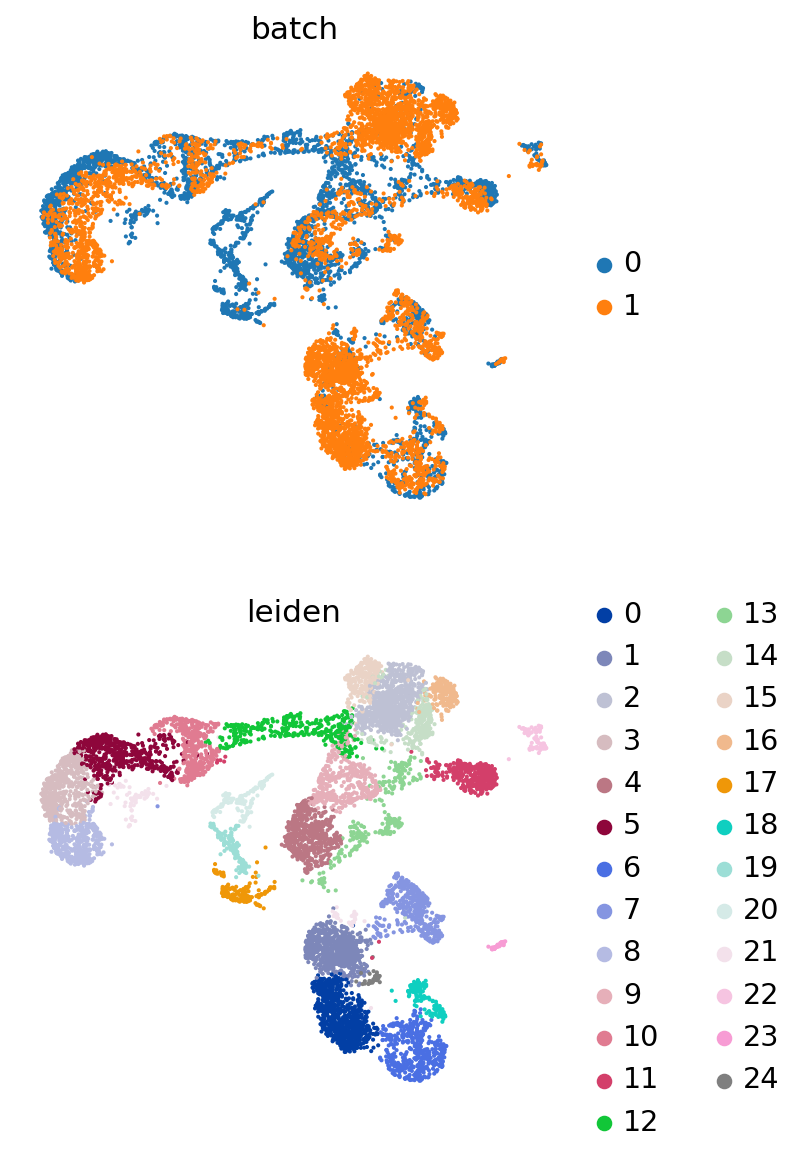

In [25]:
sc.pl.umap(
    adata,
    color=['batch', 'leiden'],
    frameon=False,
    ncols=1
)

Because this combination of datasets is used for benchmarking purposes, we have access here to curated annotations. We can use those to assess whether the harmonization worked reasonably well.

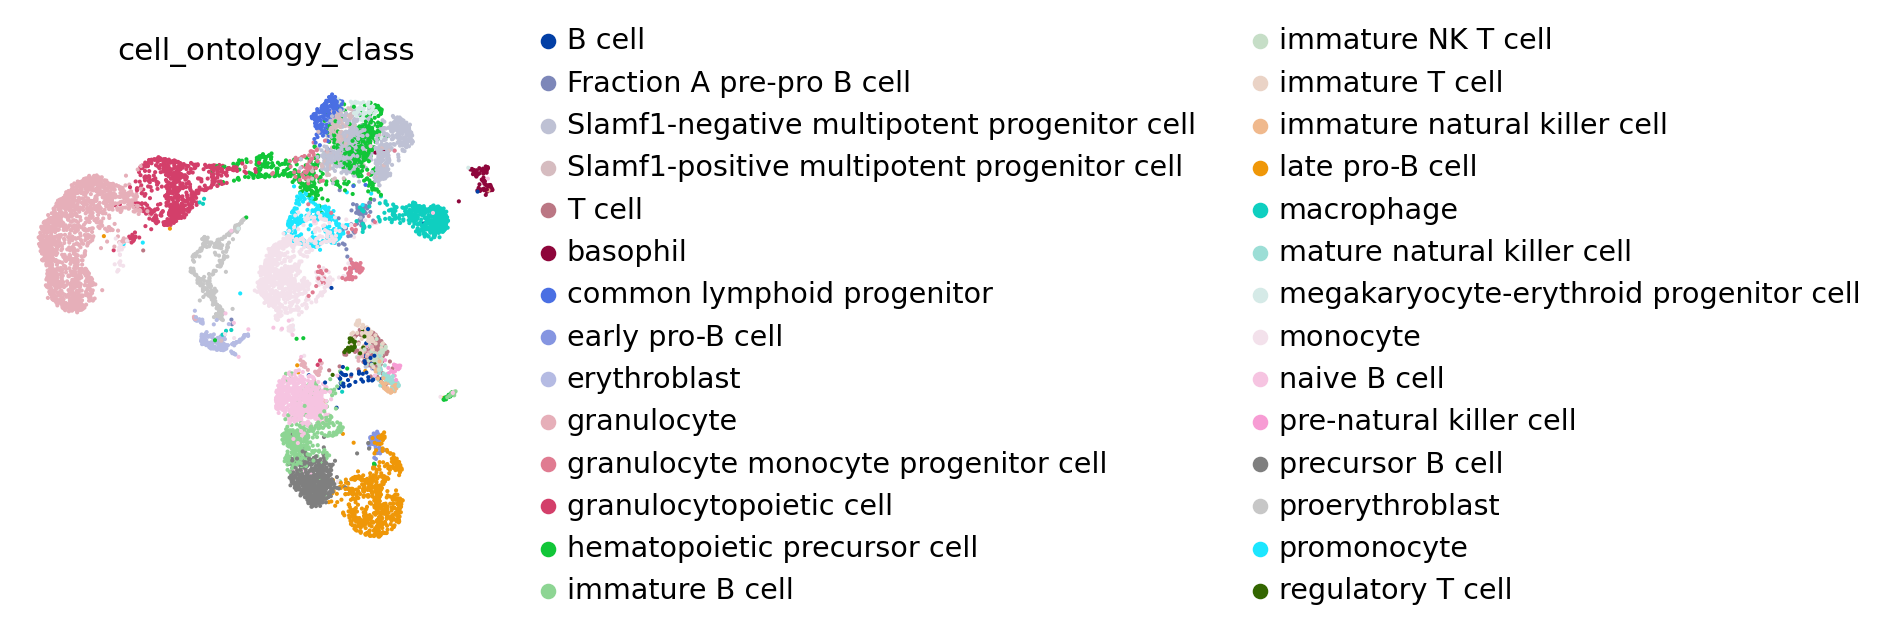

In [26]:
sc.pl.umap(adata, color='cell_ontology_class', frameon=False)

## Transfer of annotations with scANVI
We now investigate a different although complementary problem. Previously, we used scVI as we assumed we did not have any cell type annotation available to guide us. Consequently, one would need to use marker genes in order to annotate the clusters from the previous analysis.
Now, we assume that one dataset plays the role of the reference data, with known labels, and one is the query. We will use scANVI to transfer our cell type knowledge from the reference to the query data. For this, we simply need to indicate to indicate to scANVI:

- the sample identifier for each cell (as in scVI)

- the cell type, or an unnassigned label for each cell

In [27]:
# assume Smartseq2 is annotated and 10x is not
adata.obs["celltype_scanvi"] = 'Unknown'
ss2_idx = adata.obs['batch'] == "1"
adata.obs["celltype_scanvi"][ss2_idx] = adata.obs.cell_ontology_class[ss2_idx]

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


In [28]:
np.unique(adata.obs["celltype_scanvi"], return_counts = True)

(array(['B cell', 'Slamf1-negative multipotent progenitor cell',
        'Slamf1-positive multipotent progenitor cell', 'Unknown',
        'basophil', 'common lymphoid progenitor', 'granulocyte',
        'granulocyte monocyte progenitor cell', 'granulocytopoietic cell',
        'hematopoietic precursor cell', 'immature B cell',
        'immature NK T cell', 'immature T cell',
        'immature natural killer cell', 'late pro-B cell', 'macrophage',
        'mature natural killer cell',
        'megakaryocyte-erythroid progenitor cell', 'monocyte',
        'naive B cell', 'pre-natural killer cell', 'precursor B cell',
        'regulatory T cell'], dtype=object),
 array([  44,  713,  134, 3652,   25,  156,  761,  134,  221,  265,  344,
          37,   60,   36,  306,  173,   49,   55,  266,  692,   22,  517,
          27]))

In [29]:
scvi.data.setup_anndata(
    adata,
    layer='counts',
    batch_key='batch',
    labels_key='celltype_scanvi',
)

INFO     Using batches from adata.obs["batch"]                                               
INFO     Using labels from adata.obs["celltype_scanvi"]                                      
INFO     Using data from adata.layers["counts"]                                              
INFO     Computing library size prior per batch                                              
INFO     Successfully registered anndata object containing 8689 cells, 2000 vars, 2 batches, 
         23 labels, and 0 proteins. Also registered 0 extra categorical covariates and 0     
         extra continuous covariates.                                                        
INFO     Please do not further modify adata until model is trained.                          


In [30]:
lvae = scvi.model.SCANVI(adata, 'Unknown', n_latent=30, n_layers=2)

In [31]:
lvae.train(max_epochs=100, n_samples_per_label=100)

INFO     Training for 100 epochs.                                                            


GPU available: True, used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 100/100: 100%|██████████| 100/100 [02:17<00:00,  1.37s/it, loss=1.67e+03, v_num=1]


In [32]:
adata.obs['C_scANVI'] = lvae.predict(adata)
adata.obsm['X_scANVI'] = lvae.get_latent_representation(adata)

In [33]:
sc.pp.neighbors(adata, use_rep='X_scANVI')
sc.tl.umap(adata)

... storing 'celltype_scanvi' as categorical
... storing 'C_scANVI' as categorical


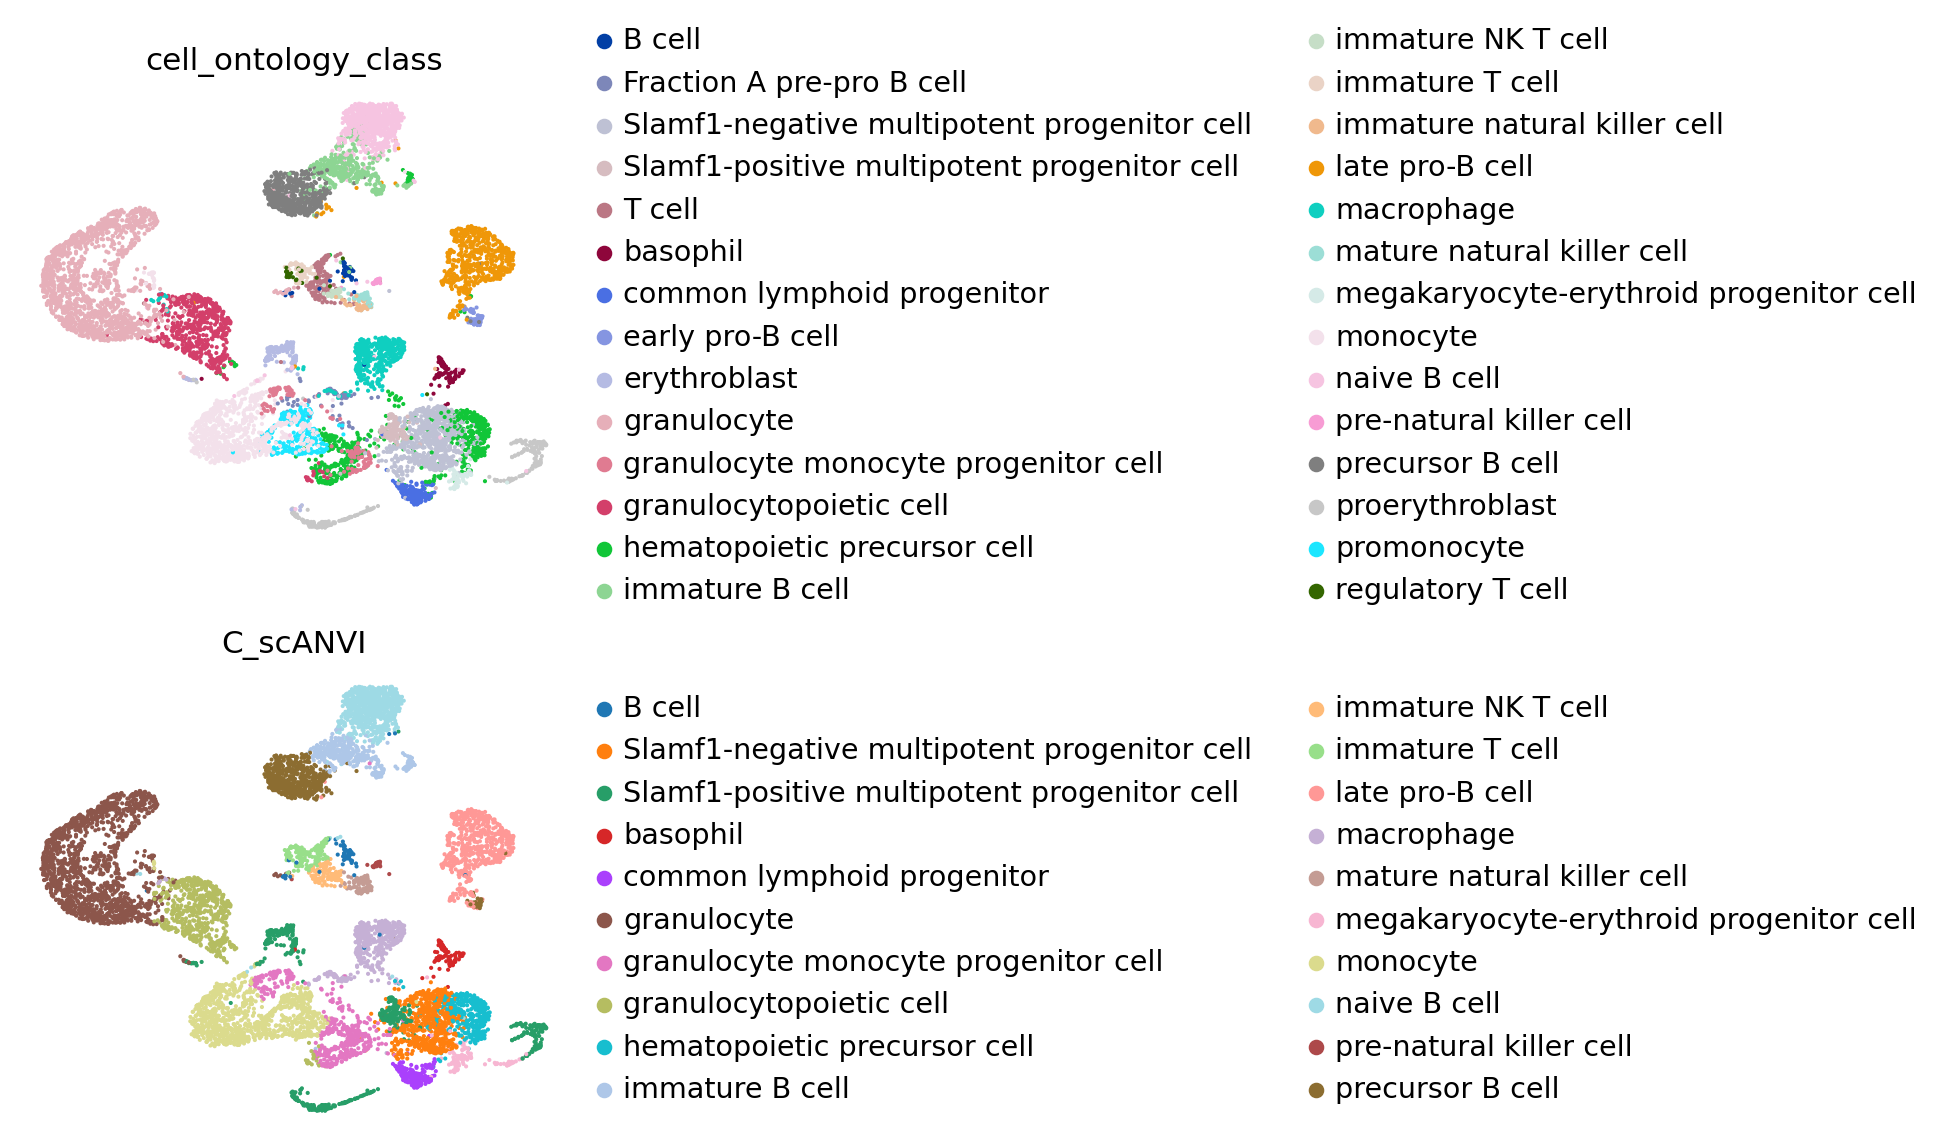

In [34]:
sc.pl.umap(adata, color=['cell_ontology_class', 'C_scANVI'], ncols=1, frameon=False)

In [35]:
# Observe scANVI's performance using confusion matrix
df = adata.obs.groupby(["cell_ontology_class", "C_scANVI"]).size().unstack(fill_value=0)
df = df / df.sum(axis=0)

plt.figure(figsize=(8, 8))
_ = plt.pcolor(df)
_ = plt.xticks(np.arange(0.5, len(df.columns), 1), df.columns, rotation=90)
_ = plt.yticks(np.arange(0.5, len(df.index), 1), df.index)
plt.xlabel("Predicted")
plt.ylabel("Observed")

scANVI's latent space separates all cell types and performs well at classifying major cell types. Since the 10X data is labelled at lower resolution, the transferred labels are not always identical with the original label. However, biologically, the transferred labels are subsets of the original labels.

In [36]:
! du -hs *

702M	data
55M	sample_data


In [37]:
! rm -r data